# Model One
### Logistic Regression, Random Forest, Extra Trees Classifier

This Notbook should predict whether a certain path in a model should be animated or not based on the embedding and additional features created.

For training we are using self-labeled data.

In [1]:
import os
os.chdir("..")

In [15]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pprint import pprint

### 1. Load and map data

Delete rows of logo_id (provided through filename) and order_id (not important)

In [3]:
target = pd.read_csv("data/model_1/animation_path_label.csv")
target["logo"] = target["logo_id"].apply(lambda row: "logo_" + str(row)) # set up logo numeration for labeling
target = target.drop(['logo_id','order_id','filename'], axis = 1) # drop unnecessary attributes
target['animation_id'] = target['animation_id'].astype(int) #transform animation_id to int for mapping with feature table
target=target.rename(columns={"logo": "filename"}) # transform for feature mapping
target.head()

,animation_id,animate,filename
0,5,0.5625,logo_0
1,0,0.5625,logo_0
2,2,0.5625,logo_0
3,4,0.6250,logo_0
4,3,0.5000,logo_0


Load an match of training data

In [4]:
X_train = pd.read_csv("data/model_1/model_1_train.csv")
X_train = X_train.drop("Unnamed: 0", axis=1) # Delete unneccessary columnd which was copied as indice
X_train.head()

,filename,animation_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg,nr_commands
0,logo_0,1,10.562015,8.770656,-0.916663,5.199933,4.420476,0.817757,-3.739024,0.105256,...,0.0,0.0,0.0,0.0,0.391017,0.458231,0.706957,0.577049,10,7
1,logo_0,0,-8.317236,6.878113,-0.472538,7.917234,2.810015,-0.228223,-5.331752,-1.496500,...,0.0,0.0,0.0,0.0,0.488551,0.651937,0.267174,0.355178,10,7
2,logo_0,3,1.680082,-1.125985,-1.630961,3.258000,6.594251,0.607164,-1.065970,0.598482,...,0.0,0.0,0.0,0.0,0.391042,0.458231,0.315928,0.577049,10,4
3,logo_0,2,6.479710,0.251655,-2.374817,3.750611,4.354021,3.803055,2.596641,5.463080,...,0.0,0.0,0.0,0.0,0.769168,0.318733,0.511441,0.840633,10,5
4,logo_0,5,8.822339,12.011980,-2.937325,6.540647,6.614409,1.779157,2.774776,1.569061,...,0.0,0.0,0.0,0.0,0.488551,0.651931,0.755725,0.355181,10,7


Merge Darframe based on the paths for which we have an annotation (df)

In [5]:
new_df = pd.merge(target, X_train,  how='left', left_on=['filename','animation_id'], right_on=['filename','animation_id'])
new_df.head(5)

,animation_id,animate,filename,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg,nr_commands
0,5,0.5625,logo_0,8.822339,12.011980,-2.937325,6.540647,6.614409,1.779157,2.774776,...,0.0,0.0,0.0,0.0,0.488551,0.651931,0.755725,0.355181,10.0,7.0
1,0,0.5625,logo_0,-8.317236,6.878113,-0.472538,7.917234,2.810015,-0.228223,-5.331752,...,0.0,0.0,0.0,0.0,0.488551,0.651937,0.267174,0.355178,10.0,7.0
2,2,0.5625,logo_0,6.479710,0.251655,-2.374817,3.750611,4.354021,3.803055,2.596641,...,0.0,0.0,0.0,0.0,0.769168,0.318733,0.511441,0.840633,10.0,5.0
3,4,0.6250,logo_0,-2.500927,4.911245,0.478100,4.769205,5.232044,2.419760,-3.308482,...,0.0,0.0,0.0,0.0,0.573461,0.306260,0.511553,0.194615,10.0,4.0
4,3,0.5000,logo_0,1.680082,-1.125985,-1.630961,3.258000,6.594251,0.607164,-1.065970,...,0.0,0.0,0.0,0.0,0.391042,0.458231,0.315928,0.577049,10.0,4.0


Delete rows in which we have NaN embeddings

In [6]:
new_df = new_df.dropna(axis=0,thresh=4)

Load Test data set and drop same features

In [7]:
X_test = pd.read_csv("data/model_1/model_1_test.csv")
X_test = X_test.drop("Unnamed: 0",axis=1)
X_test.head()

,filename,animation_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg,nr_commands
0,logo_147,1,-8.580712,1.445001,6.086452,-1.688312,0.386430,-0.192612,-0.271854,0.078169,...,22.076923,-22.076923,34.769231,-34.769231,0.025447,0.357524,0.177258,0.461866,13,8
1,logo_147,0,-13.406187,2.620383,3.337130,1.685829,-0.444999,2.265860,-0.258501,-2.916405,...,22.076923,-22.076923,34.769231,-34.769231,0.074259,0.540364,0.060423,0.547507,13,39
2,logo_147,10,-0.862549,-1.560990,-4.265006,-2.384604,-0.461853,0.404346,-0.503270,0.912298,...,22.076923,134.923077,34.769231,121.230769,0.017044,0.085221,0.183468,0.182756,13,6
3,logo_147,12,-2.929062,6.197885,0.195421,-0.633129,-0.316985,-2.096544,-0.309565,-1.425081,...,22.076923,42.923077,34.769231,113.230769,0.055225,0.207291,0.502015,0.221658,13,12
4,logo_147,2,-4.744513,3.967743,8.193521,-0.849472,-0.695401,-0.071085,-1.733007,-0.007764,...,22.076923,-22.076923,34.769231,-34.769231,0.047815,0.364758,0.131559,0.458241,13,5


In [8]:
test_df = pd.merge(target, X_test,  how='left', left_on=['filename','animation_id'], right_on=['filename','animation_id'])
test_df = test_df.dropna(axis=0, thresh=4)
test_df.head()

,animation_id,animate,filename,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg,nr_commands
1150,11,1.0,logo_147,0.052192,3.997199,9.032882,1.360194,-1.200632,-2.546890,-0.764405,...,22.076923,42.923077,34.769231,113.230769,0.172791,0.610861,0.418358,0.576557,13.0,12.0
1151,3,0.0,logo_147,-3.096901,-9.545478,8.697779,2.279099,-0.853069,1.134622,-2.476370,...,22.076923,-22.076923,34.769231,-34.769231,0.113487,0.364979,0.259243,0.458139,13.0,239.0
1152,5,0.0,logo_147,10.314985,-0.400303,1.410217,-1.346230,-0.102084,2.170840,-0.173502,...,22.076923,-22.076923,34.769231,-34.769231,0.074262,0.540355,0.832217,0.547495,13.0,13.0
1153,4,0.0,logo_147,-0.715604,3.224013,3.547626,-1.993535,0.327364,2.055381,-0.635915,...,22.076923,-22.076923,34.769231,-34.769231,0.074263,0.540364,0.595574,0.547499,13.0,26.0
1154,0,0.0,logo_147,-13.406187,2.620383,3.337130,1.685829,-0.444999,2.265860,-0.258501,...,22.076923,-22.076923,34.769231,-34.769231,0.074259,0.540364,0.060423,0.547507,13.0,39.0


### 2. Feature Selection

We want to take a look on the correlation matrix to identify features which can be excluded upfront.

C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


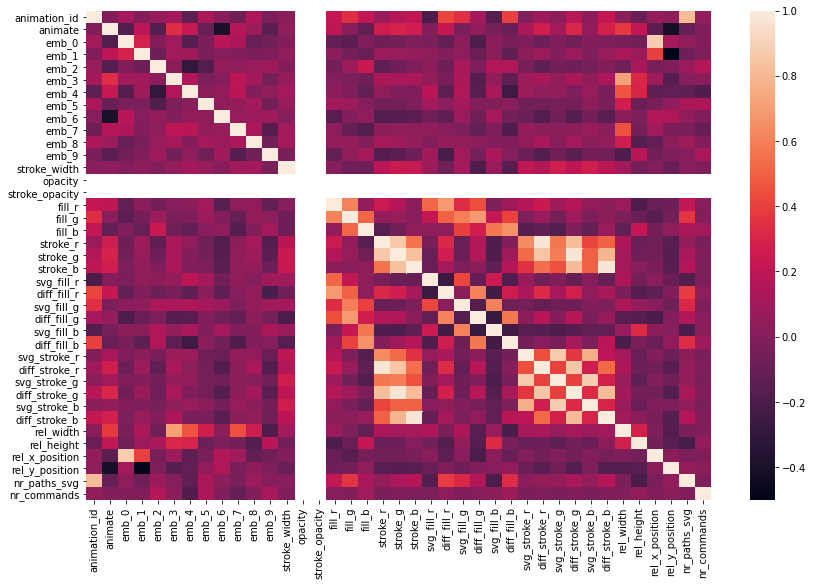

In [9]:
corrMatrix = new_df.corr()
f = plt.figure(figsize=(14, 9))
sn.heatmap(corrMatrix, annot=False)
f.show()

Since both _opacity_ and _stroke_opacity_ are always of value *one* we exclude them.

In [10]:
new_df = new_df.drop(['opacity','stroke_opacity'], axis=1, errors='ignore')
test_df = test_df.drop(['opacity','stroke_opacity'], axis= 1, errors='ignore')

Also exclude stroke attributes because they are mostly not given.

In [11]:
new_df = new_df.drop(['stroke_r','stroke_g', 'stroke_b', 'stroke_width'], axis= 1, errors='ignore')
new_df = new_df.drop(['svg_stroke_r', 'diff_stroke_r'], axis= 1, errors='ignore')
new_df = new_df.drop(['svg_stroke_g', 'diff_stroke_g'], axis= 1, errors='ignore')
new_df = new_df.drop(['svg_stroke_b', 'diff_stroke_b'], axis= 1, errors='ignore')

test_df = test_df.drop(['stroke_r','stroke_g', 'stroke_b', 'stroke_width'], axis= 1, errors='ignore')
test_df = test_df.drop(['svg_stroke_r', 'diff_stroke_r'], axis= 1, errors='ignore')
test_df = test_df.drop(['svg_stroke_g', 'diff_stroke_g'], axis= 1, errors='ignore')
test_df = test_df.drop(['svg_stroke_b', 'diff_stroke_b'], axis= 1, errors='ignore')

Check for features that have a to high correlation.

In [12]:
correlated_features = set()
correlation_matrix = new_df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Drop the following features: {correlated_features}")
#corr_features = list(correlated_features)
#test_df = test_df.drop(corr_features, axis=1, errors='ignore')
#new_df = new_df.drop(corr_features, axis=1, errors='ignore')

The following features are correlated: rel_x_position and emb_0. Correlation = 0.88
The following features are correlated: nr_paths_svg and animation_id. Correlation = 0.81
Drop the following features: {'nr_paths_svg', 'rel_x_position'}


Animation ID is only an identifier and is excluded later. Only drop rel_x_position for logistic regression (is done later). Decision Trees are not affected by multicollinearity in features.

### 3. Preprocessing

Add function that replaces animate decision with binary integrer values

In [13]:
new_df['animate']=[0 if x < 0.5 else 1 for x in new_df['animate']]
test_df['animate']=[0 if x < 0.5 else 1 for x in test_df['animate']]

#### Perform split between features and target

In [14]:
x_train = new_df.drop(['filename','animation_id','animate'], axis=1, errors='ignore')
y_train = new_df['animate']
x_test = test_df.drop(['filename','animation_id','animate'], axis=1, errors='ignore')
y_test = test_df['animate']

### 4. Implement models

#### 4.1 Random Forest

#### Randomized search on hyperparameters

In [24]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 240, 460, 680, 900, 1120, 1340, 1560, 1780, 2000]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=240; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=240; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=240; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.9s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  10.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.5s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1120;

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 240, 460, 680, 900,
                                                         1120, 1340, 1560, 1780,
                                                         2000]},
                   random_state=42, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 240,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 90,
 'bootstrap': True}

In [37]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
y_pred = base_model.predict(x_test)
print(f'Accuracy of random forest classifier on test set without hyperparameter optimization: {base_model.score(x_test, y_test)}')

Accuracy of random forest classifier with 261 estimators on test set: 0.8910614525139665


In [38]:
best_random = rf_random.best_estimator_
best_random.fit(x_train, y_train)
y_pred = best_random.predict(x_test)
print(f'Accuracy of random forest classifier on test set with hyperparameter optimization: {best_random.score(x_test, y_test)}')

Accuracy of random forest classifier with 261 estimators on test set: 0.9189944134078212


In [39]:
# save model
filename = 'models/model_1_random_forest.sav'
pickle.dump(best_random, open(filename, 'wb'))

In [18]:
# load model
loaded_model = pickle.load(open('models/model_1_random_forest.sav', 'rb'))
y_pred = loaded_model.predict(x_test)
result = loaded_model.score(x_test, y_test)
print(result)

0.9189944134078212


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       267
           1       0.87      0.80      0.83        91

    accuracy                           0.92       358
   macro avg       0.90      0.88      0.89       358
weighted avg       0.92      0.92      0.92       358



#### 4.2 Extra Trees Classifier

In [18]:
et = ExtraTreesClassifier(random_state=17)
et.fit(x_train, y_train)

ExtraTreesClassifier(random_state=17)

In [19]:
# 0.94
y_pred = et.predict(x_test)
print('Accuracy of extra forest classifier on test set: {:.2f}'.format(et.score(x_test, y_test)))

Accuracy of extra forest classifier on test set: 0.94


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       267
           1       0.91      0.87      0.89        91

    accuracy                           0.94       358
   macro avg       0.93      0.92      0.93       358
weighted avg       0.94      0.94      0.94       358



#### 4.3 XGBoost

In [22]:
# 0.91
xgb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print('Accuracy of XGBoost on test set: {:.2f}'.format(xgb.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       267
           1       0.80      0.88      0.84        91

    accuracy                           0.91       358
   macro avg       0.88      0.90      0.89       358
weighted avg       0.92      0.91      0.91       358



#### 4.4 Logistic Regression

Features which are correlated to strong are ignored

In [21]:
x_train_lr = x_train.drop(['rel_x_position'], axis=1, errors='ignore')
x_test_lr = x_test.drop(['rel_x_position'], axis= 1, errors='ignore')

Now we perform the actual regression

In [23]:
logreg = LogisticRegression(solver='lbfgs', max_iter=200000)
logreg.fit(x_train_lr, y_train)

LogisticRegression(max_iter=200000)

In [25]:
# 0.86
y_pred = logreg.predict(x_test_lr)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test_lr, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


In [ ]:
print(classification_report(y_test, y_pred))

### Result

Extra Trees Classifier performed best

In [28]:
# save model
filename = 'models/model_1_extra_trees_classifier.sav'
pickle.dump(et, open(filename, 'wb'))

In [30]:
# load model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.9441340782122905
